<a href="https://colab.research.google.com/github/narendersurabhi/tradingLibrary/blob/main/Fundamental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Empty DataFrame
Columns: [Current Ratio, Quick Ratio, Debt-to-Equity, Working Capital, Asset Turnover, Inventory Turnover, ROE, Net Margin]
Index: []


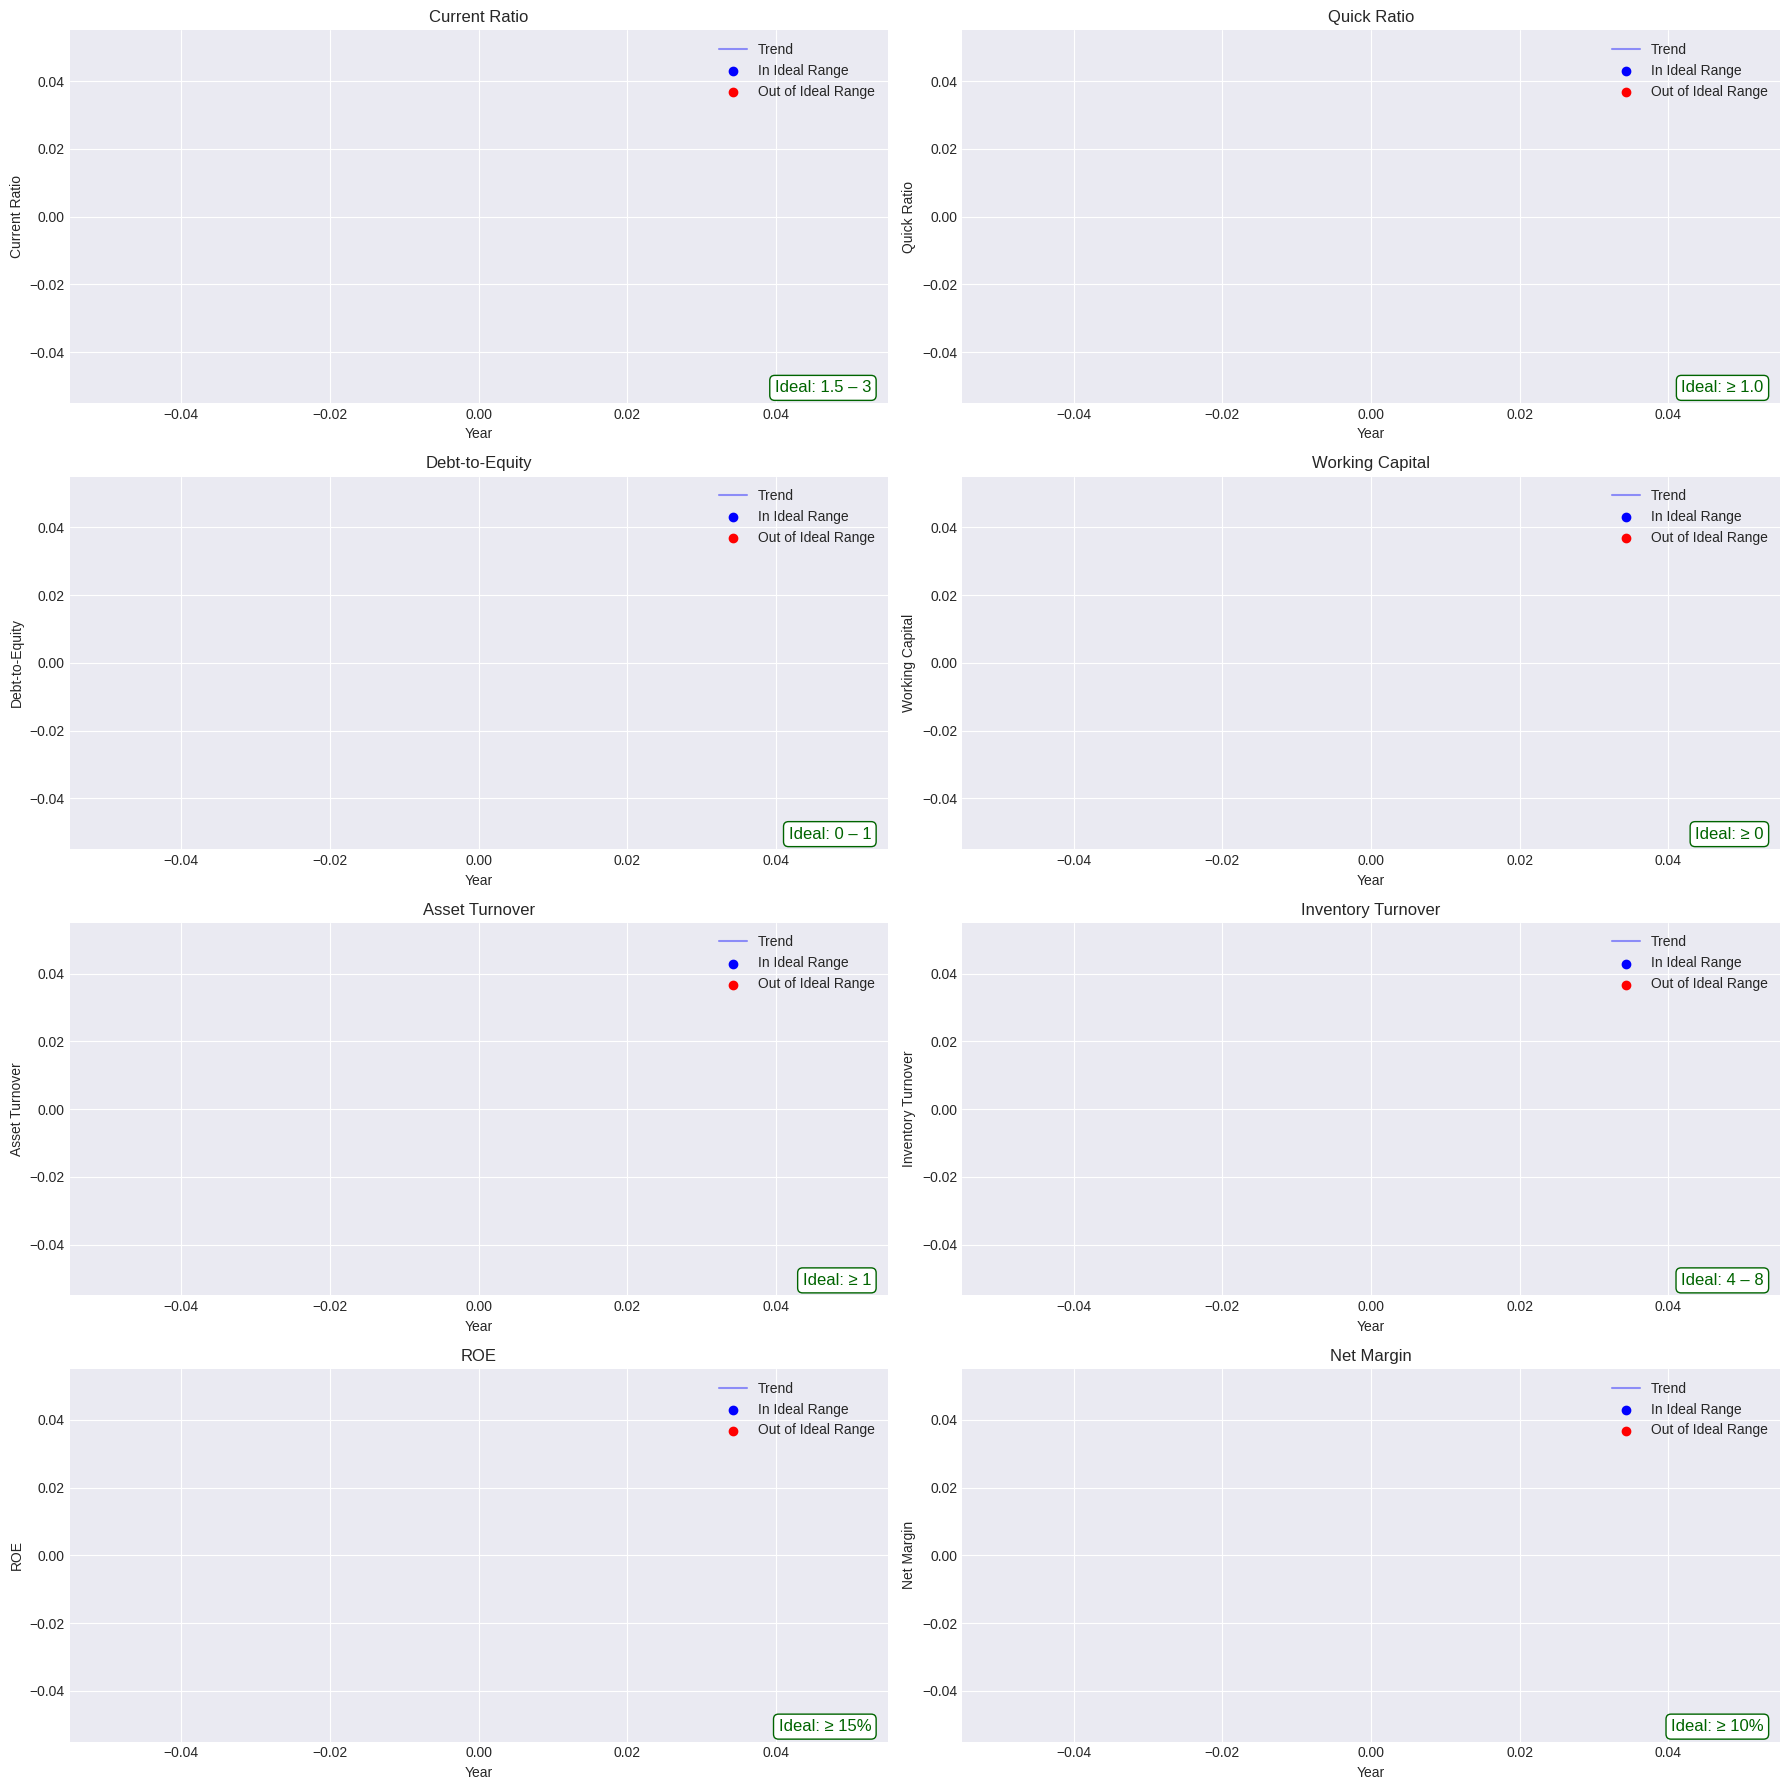

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_financial_ratios_trend(ticker):
    stock = yf.Ticker(ticker)
    bs = stock.balance_sheet
    is_ = stock.financials

    years = bs.columns[::-1]  # Chronological order

    data = {
        'Current Ratio': [],
        'Quick Ratio': [],
        'Debt-to-Equity': [],
        'Working Capital': [],
        'Asset Turnover': [],
        'Inventory Turnover': [],
        'ROE': [],
        'Net Margin': [],
        'Year': []
    }

    for col in years:
        def get_value(df, key):
            try:
                return df.loc[key, col]
            except Exception:
                return None

        current_assets = get_value(bs, 'Current Assets')
        current_liabilities = get_value(bs, 'Current Liabilities')
        inventory = get_value(bs, 'Inventory') or 0
        total_debt = get_value(bs, 'Total Debt')
        equity = get_value(bs, 'Stockholders Equity')
        total_assets = get_value(bs, 'Total Assets')
        revenue = get_value(is_, 'Total Revenue')
        cogs = get_value(is_, 'Cost Of Revenue')
        net_income = get_value(is_, 'Net Income')

        current_ratio = (current_assets / current_liabilities) if current_assets and current_liabilities else None
        quick_ratio = ((current_assets - inventory) / current_liabilities) if current_assets and current_liabilities is not None else None
        debt_to_equity = (total_debt / equity) if total_debt and equity else None
        working_capital = (current_assets - current_liabilities) if current_assets and current_liabilities else None
        asset_turnover = (revenue / total_assets) if revenue and total_assets else None
        inventory_turnover = (cogs / inventory) if cogs and inventory else None
        roe = (net_income / equity) if net_income and equity else None
        net_margin = (net_income / revenue) if net_income and revenue else None

        data['Year'].append(str(col.year))
        data['Current Ratio'].append(current_ratio)
        data['Quick Ratio'].append(quick_ratio)
        data['Debt-to-Equity'].append(debt_to_equity)
        data['Working Capital'].append(working_capital)
        data['Asset Turnover'].append(asset_turnover)
        data['Inventory Turnover'].append(inventory_turnover)
        data['ROE'].append(roe)
        data['Net Margin'].append(net_margin)

    df = pd.DataFrame(data)
    df.set_index('Year', inplace=True)
    return df

# Define ideal ranges for each ratio
ideal_ranges = {
    'Current Ratio': (1.5, 3),
    'Quick Ratio': (1, np.inf),
    'Debt-to-Equity': (0, 1),
    'Working Capital': (0, np.inf),
    'Asset Turnover': (1, np.inf),
    'Inventory Turnover': (4, 8),
    'ROE': (0.15, np.inf),  # 15% or higher
    'Net Margin': (0.10, np.inf),  # 10% or higher
}

def format_ideal_range(ratio):
    low, high = ideal_ranges[ratio]
    if np.isinf(high):
        if ratio in ['ROE', 'Net Margin']:
            return f"Ideal: ≥ {low*100:.0f}%"
        elif ratio == 'Quick Ratio':
            return f"Ideal: ≥ {low:.1f}"
        else:
            return f"Ideal: ≥ {low}"
    else:
        if ratio in ['ROE', 'Net Margin']:
            return f"Ideal: {low*100:.0f}% – {high*100:.0f}%"
        else:
            return f"Ideal: {low} – {high}"

def is_ideal(ratio, value):
    if value is None or np.isnan(value):
        return None
    low, high = ideal_ranges[ratio]
    return low <= value <= high

# Example usage
ticker = 'CMG'
ratios_df = get_financial_ratios_trend(ticker)
print(ratios_df)

# Plotting with red markers for out-of-range values and ideal range annotation
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(4, 2, figsize=(18, 18))
axes = axes.flatten()

for idx, column in enumerate(ratios_df.columns):
    y = ratios_df[column].astype(float)
    x = ratios_df.index

    ideal_mask = y.apply(lambda v: is_ideal(column, v))

    axes[idx].plot(x, y, color='blue', alpha=0.4, label='Trend')
    axes[idx].scatter(x[ideal_mask==True], y[ideal_mask==True], color='blue', label='In Ideal Range')
    axes[idx].scatter(x[ideal_mask==False], y[ideal_mask==False], color='red', label='Out of Ideal Range')
    axes[idx].set_title(column)
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel(column)
    axes[idx].grid(True)
    axes[idx].legend()
    # Add ideal range annotation
    axes[idx].text(
        0.98, 0.02, format_ideal_range(column),
        transform=axes[idx].transAxes,
        fontsize=12,
        color='darkgreen',
        ha='right', va='bottom',
        bbox=dict(facecolor='white', edgecolor='darkgreen', boxstyle='round,pad=0.3')
    )

plt.tight_layout()
plt.show()
